# LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, save, load
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from sklearn.metrics import precision_score, recall_score, fbeta_score
from tabulate import tabulate
import copy
import torch.nn.init as init
from sklearn.linear_model import LinearRegression
from torch.optim.lr_scheduler import StepLR
from itertools import product
import matplotlib.patches as patches

# DEVICE CONFIGURATION

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# FIRST ORDER NETWORK ARCHITECTURE DEFINITION

In [ ]:
class FirstOrderNetwork(nn.Module):
    def __init__(self, hidden, factor, gelu):
        super(FirstOrderNetwork, self).__init__()
        # Encoder layer: Linear transformation from the input layer (100 units) to the hidden layer
        self.enc_linear = nn.Linear(100, hidden)  # Input layer size -> Hidden layer size

        # Additional hidden layer for processing within the network
        self.hidden_layer = nn.Linear(hidden, hidden)  # Hidden layer self-connection

        # Decoder layer: Linear transformation from the hidden layer back to the output layer (100 units)
        self.dec_linear = nn.Linear(hidden, 100)  # Hidden layer size -> Output layer size

        # Temperature parameter, potentially for controlling the sharpness of activations
        self.temperature = 1.0

        #determines the amount of data, factor =1 means that it's the default amount of data, 10 means 10 times the data(input data)
        self.factor=factor

        #activation functions, either GELU for a  smoother gradient transition  or RELU
        if gelu:
            self.activation = torch.nn.GELU()  # GELU activation function for smoother transitions
        else:
            self.activation = torch.relu  # ReLU activation function for standard gradient transitions

        self.sigmoid = torch.sigmoid  # Sigmoid activation for output layer, useful for binary classification or binary feature representation
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax for multi-class classification or probabilistic outputs
        self.tanh = torch.tanh  # Tanh activation, useful for generating outputs between -1 and 1

        # Initialize network weights
        self._init_weights()

    def _init_weights(self):
        # Initialize encoder, hidden layer, and decoder weights uniformly between -1.0 and 1.0
        init.uniform_(self.enc_linear.weight, -1.0, 1.0)
        init.uniform_(self.hidden_layer.weight, -1.0, 1.0)
        init.uniform_(self.dec_linear.weight, -1.0, 1.0)

    def forward(self, x):
        # Forward pass through the network with sigmoid activation and temperature adjustment
        encoded = self.sigmoid(self.enc_linear(x) / self.temperature)
        encoded = self.sigmoid(self.hidden_layer(encoded) / self.temperature)
        final_output = self.sigmoid(self.dec_linear(encoded) / self.temperature)

        # Adjust outputs where activation is greater than 0.5, simulating enhanced signal detection
        final_output = torch.where(final_output > 0.5, final_output + 0.12, final_output)
        return final_output

# SECOND ORDER NETWORK ARCHITECTURE DEFINITION

In [ ]:
class SecondOrderNetwork(nn.Module):
    def __init__(self, gelu):
        super(SecondOrderNetwork, self).__init__()
        # Comparison layer to evaluate the difference between the first-order network's input and output
        self.comparison_layer = nn.Linear(100, 100)  # Linear layer for comparing 100 units of input vs. output difference

        # These units are connected to one unit representing high and low wagers
        self.wager = nn.Linear(100, 1)

        #activation functions
        if gelu:
          self.activation=torch.nn.GELU()
        else:
          self.activation=torch.relu
        self.sigmoid = torch.sigmoid
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax activation - usually for winner takes all problems
        self.tanh=torch.tanh

        # Initialize weights
        self._init_weights()

    def _init_weights(self):

        init.uniform_(self.comparison_layer.weight, -1.0, 1.0)
        init.uniform_(self.wager.weight, 0.0, 0.1)

    def forward(self, first_order_input, first_order_output):

        comparison_matrix = first_order_input - first_order_output

        #comparisson matrix
        comparison_out = self.comparison_layer(comparison_matrix)

        wager = self.sigmoid(self.wager(comparison_out))

        return wager

#FUNCTION THAT CREATES PATTERS AND TARGETS FOR EACH EPOCH


In [ ]:
def Generate_Patterns(patterns_number, num_units):
    # Generates patterns and targets for training the networks
    # patterns_number: Number of patterns to generate
    # num_units: Number of units in each pattern
    # Returns lists of patterns, stimulus present/absent indicators, and second order targets

    patterns = []  # Store generated patterns
    stim_present = []  # Indicators for when a stimulus is present in the pattern
    stim_absent = []  # Indicators for when no stimulus is present
    order_2_pr = []  # Second order network targets based on the presence or absence of stimulus

    # Generate patterns, half noise and half potential stimuli
    for i in range(patterns_number):
        # First half: Noise patterns
        if i < patterns_number // 2:
            pattern = np.random.uniform(0.0, 0.02, num_units)  # Generate a noise pattern
            patterns.append(pattern)
            stim_present.append(np.zeros(num_units))  # Stimulus absent
            stim_absent.append(np.zeros(num_units))  # Redundant, consider removing
            order_2_pr.append(0.0)  # No stimulus, low wager
        # Second half: Stimulus patterns
        else:
            stimulus_number = random.randint(0, num_units - 1)  # Choose a unit for potential stimulus
            pattern = np.random.uniform(0.0, 0.02, num_units)
            pattern[stimulus_number] = np.random.uniform(0.0, 1.0)  # Set stimulus intensity
            patterns.append(pattern)
            present = np.zeros(num_units)
            # Determine if stimulus is above discrimination threshold
            if pattern[stimulus_number] >= 0.5:
                order_2_pr.append(1.0)  # Stimulus detected, high wager
                present[stimulus_number] = 1.0
            else:
                order_2_pr.append(0.0)  # Stimulus not detected, low wager
                present[stimulus_number] = 0.0
            stim_present.append(present)
            stim_absent.append(np.zeros(num_units))  # Redundant, consider removing

    patterns_tensor = torch.Tensor(patterns).to(device)
    stim_present_tensor = torch.Tensor(stim_present).to(device)
    stim_absent_tensor= torch.Tensor(stim_absent).to(device)
    order_2_tensor = torch.Tensor(order_2_pr).to(device)

    return patterns_tensor, stim_present_tensor , stim_absent_tensor, order_2_tensor


# Function that performs linear regression

In [ ]:
#calculates linear approximation function to graph on the plots

def perform_linear_regression(epoch_list, precision):
    # Perform linear regression
    X = np.array(epoch_list).reshape(-1, 1)
    y = np.array(precision)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    return y_pred

#ASSIGNMENT OF FIRST AND SECOND ORDER NETWORK, AND DEFINITION OF CRITERIONS


In [ ]:
#define the architecture, optimizers, loss functions, and schedulers for pre training
def prepare_pre_training(hidden,factor,gelu,stepsize, gam):

  first_order_network = FirstOrderNetwork(hidden,factor,gelu).to(device)
  second_order_network = SecondOrderNetwork(gelu).to(device)

  criterion_1 = nn.MSELoss()
  criterion_2 = nn.MSELoss()

  optimizer_1 = optim.SGD(first_order_network.parameters(), lr=learning_rate_1, momentum=momentum)
  optimizer_2 = optim.SGD(second_order_network.parameters(), lr=learning_rate_2, momentum=momentum)


  # Learning rate schedulers
  scheduler_1 = StepLR(optimizer_1, step_size=stepsize, gamma=gam)
  scheduler_2 = StepLR(optimizer_2, step_size=stepsize, gamma=gam)

  return first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2

# PRE TRAINING LOOP

In [ ]:
def pre_train(first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, factor, meta):
    # Pre-train function for both the first-order and second-order networks.
    # - first_order_network: The autoassociator network learning the basic input-output mapping.
    # - second_order_network: The network learning to wager based on the comparison of first-order input and output.
    # - criterion_1 & criterion_2: Loss functions for the first-order and second-order networks respectively.
    # - optimizer_1 & optimizer_2: Optimizers for updating weights of the first-order and second-order networks.
    # - scheduler_1 & scheduler_2: Learning rate schedulers for adjusting the learning rates of the optimizers over time.
    # - factor: A parameter used for data augmentation.
    # - meta: A boolean indicating if meta-learning is applied, affecting how losses are calculated and backpropagated.

    for epoch in range(n_epochs):
        # Generate training patterns and targets for each epoch.
        patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

        # Forward pass through the first-order network.
        output_first_order = first_order_network(patterns_tensor)

        # Forward pass through the second-order network with inputs from the first-order network.
        output_second_order = second_order_network(patterns_tensor, output_first_order)

        # Calculate the loss for the second-order network (wagering decision based on comparison).
        loss_2 = criterion_2(output_second_order, order_2_tensor)

        # Calculate the loss for the first-order network (accuracy of stimulus representation).
        loss_1 = criterion_1(output_first_order, stim_present_tensor)

        # Backpropagate the second-order network's loss if meta-learning is enabled.
        if meta == True:
            loss_2.backward(retain_graph=True)  # Allows further backpropagation for loss_1 after loss_2.

        loss_1.backward(retain_graph=True)

        # Update weights
        if meta == True:
            optimizer_2.step()

        optimizer_1.step()

        # Reset gradients of optimizers to zero for the next iteration.
        if meta == True:
            optimizer_2.zero_grad()
        optimizer_1.zero_grad()

        epoch_1_order[epoch] = loss_1
        epoch_2_order[epoch] = loss_2

        # Update learning rates based on the schedulers.
        if meta == True:
            scheduler_2.step()
        scheduler_1.step()

        patterns_matrix1[epoch] = order_2_tensor

    return first_order_network, second_order_network, epoch_1_order, epoch_2_order, patterns_matrix1


# LOSS PLOT

In [ ]:
def pre_train_plots(epoch_1_order, epoch_2_order, patterns_matrix, title):
    # LOSS PLOTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

    # First graph for 1st Order Network
    ax1.plot(epoch_list, epoch_1_order, linestyle='--', marker='o', color='g')
    ax1.set_title('1st Order Network Loss')
    ax1.set_xlabel('Epochs - Pretraining Phase')
    ax1.set_ylabel('Loss')

    # Second graph for 2nd Order Network
    ax2.plot(epoch_list, epoch_2_order, linestyle='--', marker='o', color='b')
    ax2.set_title('2nd Order Network Loss')
    ax2.set_xlabel('Epochs - Pretraining Phase')
    ax2.set_ylabel('Loss')

    plt.suptitle(title, fontsize=16, y=0.95)

    plt.tight_layout()
    plt.savefig('Blindsight_Pre_training_Loss_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
    plt.show()
    plt.close(fig)

    # PATTERNS USED (TARGETS) - HEATMAP PLOT
    fig, ax = plt.subplots(figsize=(10, 8))  # Here you set the figure size

    #workaround to work when using gpu
    if patterns_matrix.is_cuda:
        patterns_matrix = patterns_matrix.cpu()

    patterns_array = patterns_matrix.numpy()

    cax = ax.imshow(patterns_array, cmap='binary', aspect='auto')
    ax.set_xlabel('Pattern Elements')
    ax.set_ylabel('Epochs')
    ax.set_title('Pre-training Patterns Over Epochs')
    fig.colorbar(cax, ax=ax, label='Activation (0 or 1)')

    plt.suptitle(title, fontsize=16, y=0.95)
    plt.savefig('Blindsight_Patterns_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
    plt.show()
    plt.close(fig)

# PATTERNS FOR TESTING (Suprathreshold stimulus =0  , subthreshold =1 , low vision = 2)






In [ ]:
def create_patterns(stimulus):
    # Generates patterns for neural network input based on specified stimulus conditions.
    # - stimulus: An integer that determines the type of patterns to generate (0, 1, or 2).

    # Initial pattern generation for the base condition.
    patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

    if stimulus == 0:
        # Suprathreshold stimulus
        Set = torch.Tensor(patterns_tensor).to(device)  # Converts patterns to tensors and moves to device (CPU/GPU).
        Set_targets = torch.Tensor(stim_present_tensor).to(device)  # Converts targets to tensors and moves to device.

    elif stimulus == 1:
        # Subthreshold stimulus condition; adds noise to simulate blindsight.
        Second_set = []
        Second_set_targets = []
        for i in range(patterns_number):
            pattern = np.random.uniform(0.0, 0.02, num_units)  # Base noise pattern.
            pattern += 0.0012  # Adding noise to every input except the stimulus.
            if i >= 100:
                stimulus_number = random.randint(0, 99)  # Selects one unit for potential stimulus.
                pattern[stimulus_number] = np.random.uniform(0.0, 1.0) + 0.0012  # Adjusts stimulus with added noise.
                # Sets the target based on whether the stimulus is above the discrimination threshold.
                present = np.zeros(num_units)
                present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.5 else 0.0
                Second_set_targets.append(present)
            Second_set.append(pattern)
        Set = torch.Tensor(Second_set).to(device)
        Set_targets = torch.Tensor(Second_set_targets).to(device)

    elif stimulus == 2:
        # Low Vision condition; reduces activation of the stimuli.
        Third_set = []
        Third_set_targets = []
        for i in range(patterns_number):
            pattern = np.random.uniform(0.0, 0.02, num_units)  # Base noise pattern.
            if i >= 100:
                stimulus_number = random.randint(0, 99)
                pattern[stimulus_number] = np.random.uniform(0.0, 0.3)  # Reduced stimulus activation.
                present = np.zeros(num_units)
                present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.15 else 0.0
                Third_set_targets.append(present)
            Third_set.append(pattern)
        Set = torch.Tensor(Third_set).to(device)
        Set_targets = torch.Tensor(Third_set_targets).to(device)

    else:
        print("INVALID STIMULUS ID FOR TESTING PATTERNS CREATION")

    return Set, Set_targets



# MODEL LOADING FOR TRAINING

In [ ]:
def config_training(first_order_network , second_order_network,hidden,factor,gelu):
  #SAVING THE MODELS
  PATH = './cnn1.pth'
  PATH_2 = './cnn2.pth'

  #save the weights of the pretrained networks
  torch.save(first_order_network.state_dict(), PATH)
  torch.save(second_order_network.state_dict(), PATH_2)

  First_set , First_set_targets = create_patterns(0)
  Second_set , Second_set_targets = create_patterns(1)
  Third_set , Third_set_targets = create_patterns(2)

  Testing_patterns= [ [First_set , First_set_targets] , [Second_set , Second_set_targets] ,  [Third_set , Third_set_targets]]

  n_samples = len(Testing_patterns[0][0])

  loaded_model = FirstOrderNetwork(hidden , factor, gelu)
  loaded_model_2 = SecondOrderNetwork(gelu)

  loaded_model.load_state_dict(torch.load(PATH))
  loaded_model_2.load_state_dict(torch.load(PATH_2))

  loaded_model.to(device)
  loaded_model_2.to(device)

  loaded_model.eval()
  loaded_model_2.eval()

  return Testing_patterns , n_samples , loaded_model , loaded_model_2




# TESTING LOOP

In [ ]:
def plot_table(data, row_labels, col_labels, title,  title1):
    """Utility function to plot tables."""
    colormap=plt.cm.RdYlGn
    figsize=(5, 5)

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    colors = np.array(data) / np.max(data)
    colors = np.around(colors, decimals=2)
    ax.table(cellText=data, rowLabels=row_labels, colLabels=col_labels, cellColours=colormap(colors), loc='center')
    plt.title(title, y=0.7)
    plt.suptitle(title1, fontsize=16, y=0.8)

    safe_title = title.replace(" ", "_").replace("/", "_")
    safe_title1 = title1.replace(" ", "_").replace("/", "_")
    filename = f"Blindsight_metrics_table_{safe_title}_{safe_title1}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close(fig)

def compute_metrics(TP, FP, FN):
    """Compute precision, recall, and F1 score."""
    precision = round(TP / (TP + FP), 2) if (TP + FP) > 0 else 0
    recall = round(TP / (TP + FN), 2) if (TP + FN) > 0 else 0
    f1_score = round(2 * (precision * recall) / (precision + recall), 2) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

def testing(Testing_patterns, n_samples, loaded_model, loaded_model_2):
    Testing_graph_names = ["Suprathreshold stimulus", "Subthreshold stimulus", "Low Vision"]
    results_for_plotting = []

    f1_scores_high_wager = []
    f1_scores_low_wager = []

    for i in range(len(Testing_patterns)):
        with torch.no_grad():
            output_first_order = loaded_model(Testing_patterns[i][0])
            output_second_order = loaded_model_2(Testing_patterns[i][0] , output_first_order )
            last_100_elements_wager = output_second_order[-100:].cpu()
            percentile_50 = np.percentile(last_100_elements_wager.numpy(), 50)

            # Create a boolean mask for predictions and convert it to integers
            predicted = (last_100_elements_wager >= percentile_50).int()

            _, targets_2 = torch.max(Testing_patterns[i][1], 1)
            targets_2 = targets_2[-100:]
            targets_2 = (targets_2 >= 50).int()

            # Convert tensors to NumPy arrays for calculations
            predicted_np = predicted.cpu().numpy()
            targets_2_np = targets_2.cpu().numpy()

            TP = np.sum((predicted_np == 1) & (targets_2_np == 1))
            TN = np.sum((predicted_np == 0) & (targets_2_np == 0))
            FP = np.sum((predicted_np == 1) & (targets_2_np == 0))
            FN = np.sum((predicted_np == 0) & (targets_2_np == 1))

            precision_h, recall_h, f1_score_h = compute_metrics(TP, FP , FN)
            precision_l, recall_l, f1_score_l = compute_metrics(TP, FP , FN)

            f1_scores_high_wager.append(f1_score_h)
            f1_scores_low_wager.append(f1_score_l)

            # Store results and metrics for plotting after the loop
            results_for_plotting.append({
                "counts": [[TP, FP, TP + FP], [FN, TN, FN + TN], [TP + FN, FP + TN, TP + FP + FN + TN]],
                "metrics": [[precision_h, recall_h, f1_score_h], [precision_l, recall_l, f1_score_l]],
                "title_results": f"Results Table - {Testing_graph_names[i]}",
                "title_metrics": f"Metrics Table - {Testing_graph_names[i]}"
            })

    return f1_scores_high_wager, f1_scores_low_wager , results_for_plotting

def plot_testing(results_for_plotting , title):
    categories = ["HIGH WAGER", "LOW WAGER", "TOTAL"]
    headers = ["CORRECT", "INCORRECT", "TOTAL"]
    categories_metrics = ["HIGH WAGER", "LOW WAGER"]
    headers_metrics = ["PRECISION", "RECALL", "F1_SCORE"]
    for result in results_for_plotting:
        plot_table(result["metrics"] , categories_metrics, headers_metrics, result["title_metrics"] , title)

# MAIN CODE - TRAINING DEFINITION

In [ ]:
def train(hidden , factor, gelu , stepsize , gam , meta):

  first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2 = prepare_pre_training(hidden,factor,gelu,stepsize, gam)

  first_order_network_pre , second_order_network_pre , epoch_1_order , epoch_2_order, patterns_matrix = pre_train(first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, factor,meta)

  Testing_patterns , n_samples , loaded_model , loaded_model_2 = config_training(first_order_network_pre , second_order_network_pre ,hidden,factor,gelu)

  f1_scores_high_wager, f1_scores_low_wager , results_for_plotting = testing(Testing_patterns, n_samples, loaded_model, loaded_model_2)

  print(f"Hidden: {hidden}, Factor: {factor}, Gelu? : {gelu}, Step Size: {stepsize}, Gamma Factor: {gam}, F1-scores high wager: {f1_scores_high_wager},  F1-scores low wager: {f1_scores_low_wager}")

  # Collect data for plots
  plot_data = {
      'pre_train': (epoch_1_order, epoch_2_order, patterns_matrix),
      'test': (results_for_plotting)
  }
  return f1_scores_high_wager, f1_scores_low_wager, plot_data

def plots(plot_data , title):
  #plot the results of a trained and tested network
  pre_train_plots(*plot_data['pre_train'] , title)
  plot_testing(plot_data['test'] , title)

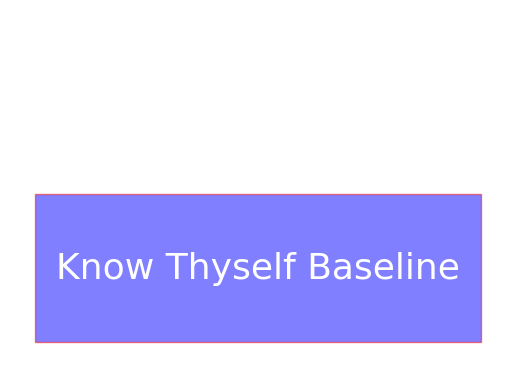

Hidden: 60, Factor: 1, Gelu? : False, Step Size: 1, Gamma Factor: 1.0, F1-scores high wager: [0.36, 0.32, 0.29],  F1-scores low wager: [0.36, 0.32, 0.29]


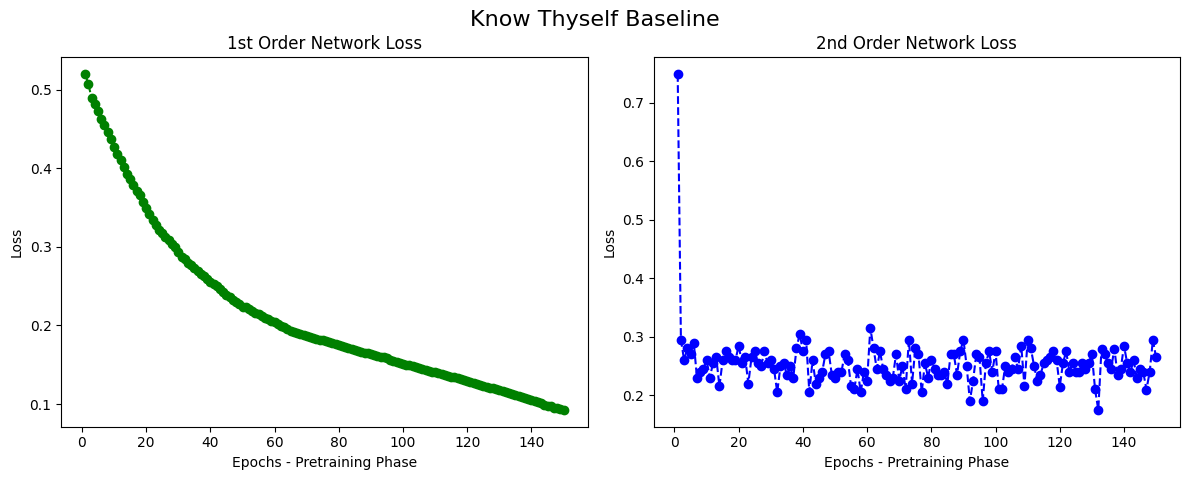

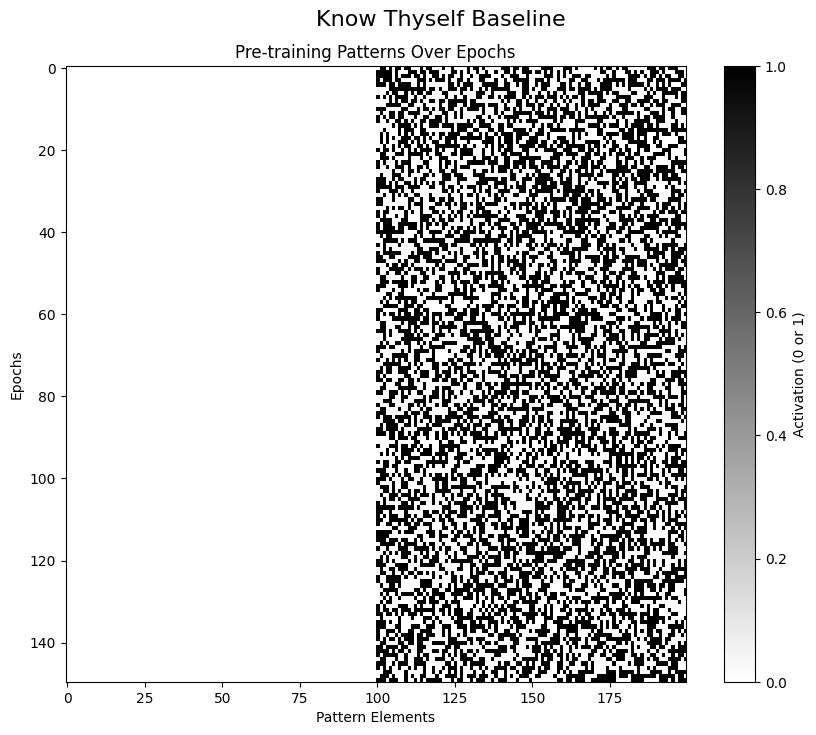

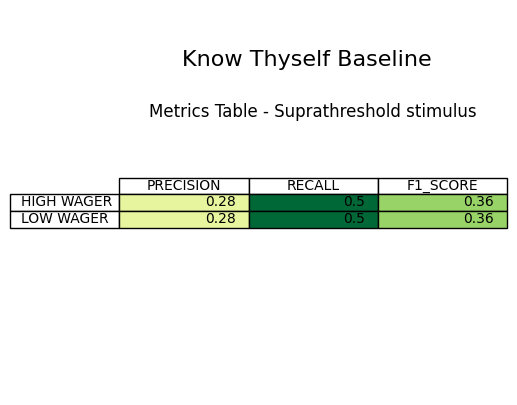

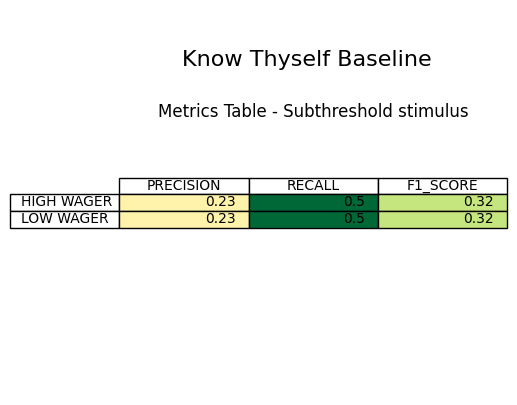

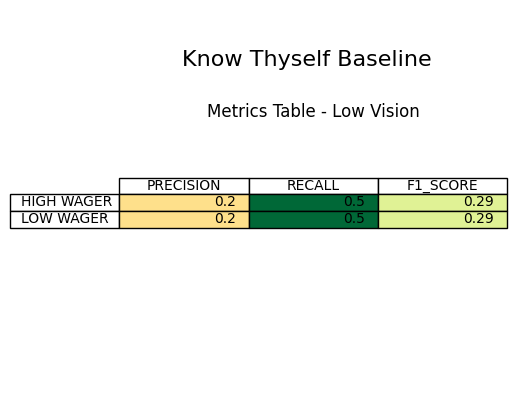

Hidden: 50, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.99, F1-scores high wager: [0.32, 0.29, 0.3],  F1-scores low wager: [0.32, 0.29, 0.3]
Hidden: 50, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.99, F1-scores high wager: [0.36, 0.35, 0.34],  F1-scores low wager: [0.36, 0.35, 0.34]
Hidden: 50, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.98, F1-scores high wager: [0.29, 0.25, 0.34],  F1-scores low wager: [0.29, 0.25, 0.34]
Hidden: 50, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.98, F1-scores high wager: [0.37, 0.35, 0.38],  F1-scores low wager: [0.37, 0.35, 0.38]
Hidden: 50, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.97, F1-scores high wager: [0.36, 0.36, 0.38],  F1-scores low wager: [0.36, 0.36, 0.38]
Hidden: 50, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.97, F1-scores high wager: [0.32, 0.35, 0.32],  F1-scores low wager: [0.32, 0.35, 0.32]
Hidden: 50, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.96, F1-scor

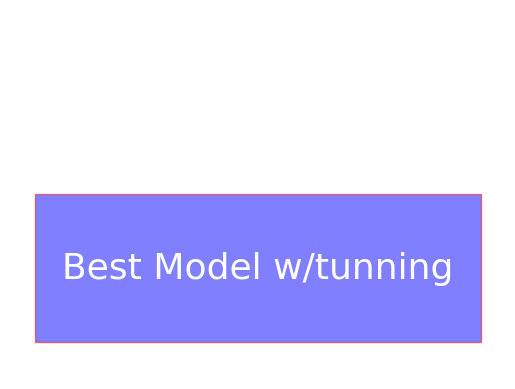

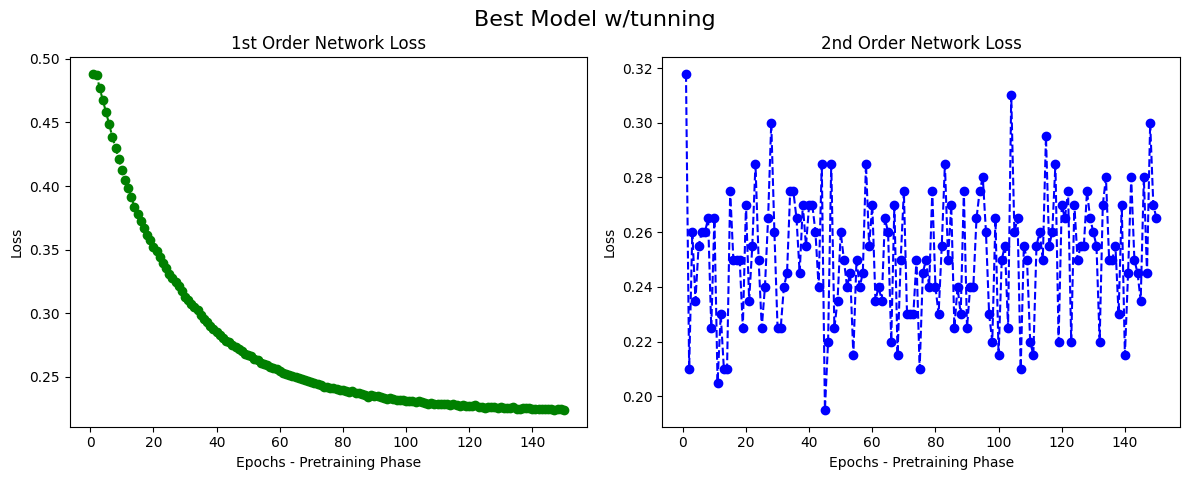

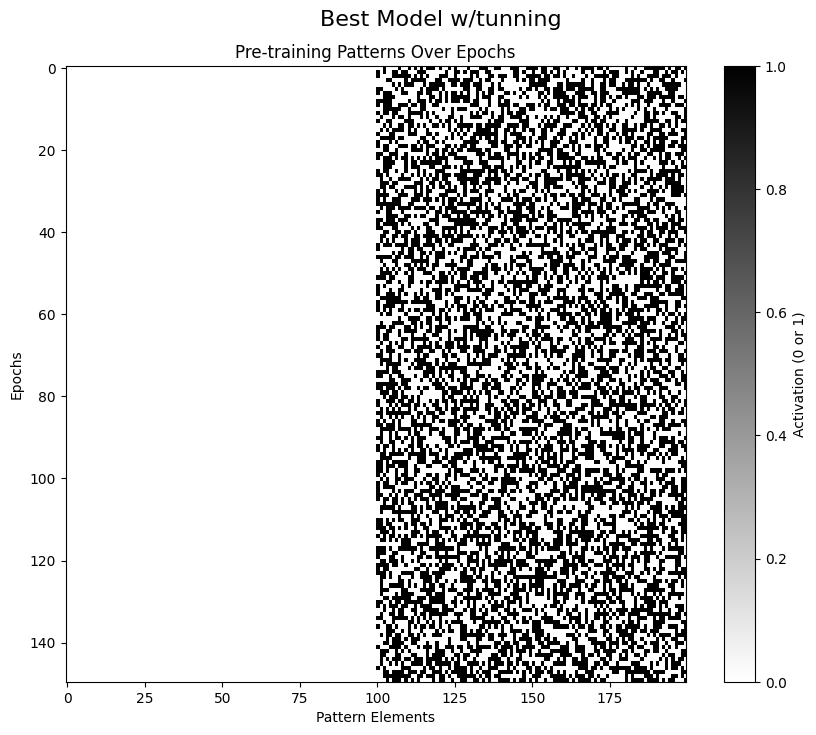

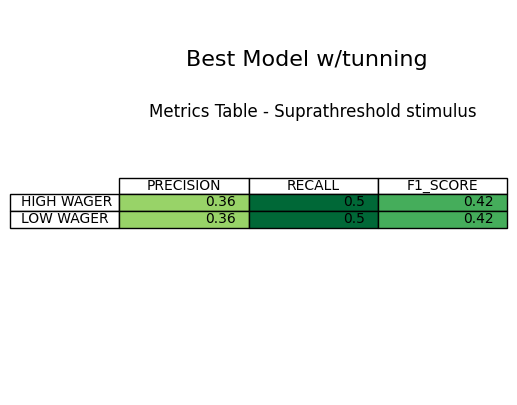

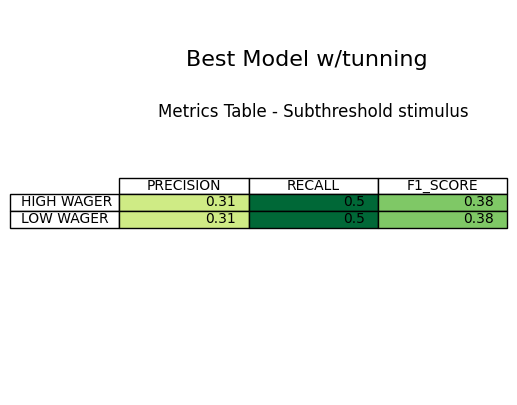

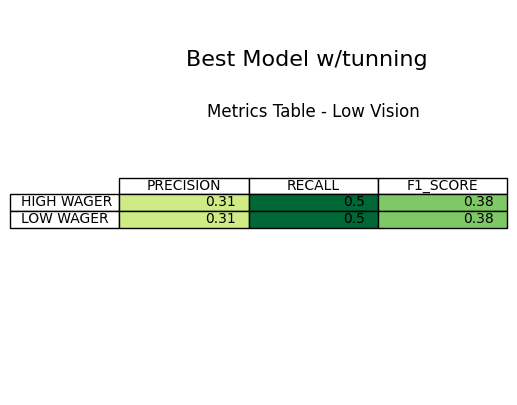

Hidden: 60, Factor: 1, Gelu? : True, Step Size: 1, Gamma Factor: 0.97, F1-scores high wager: [0.37, 0.32, 0.25],  F1-scores low wager: [0.37, 0.32, 0.25]


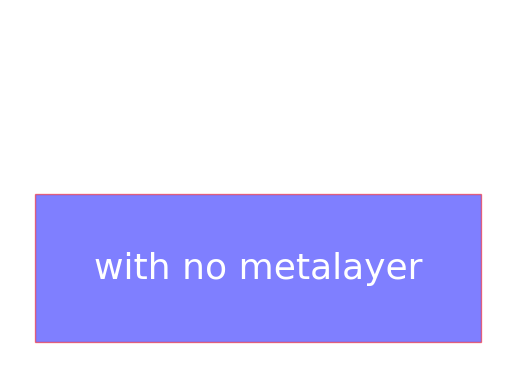

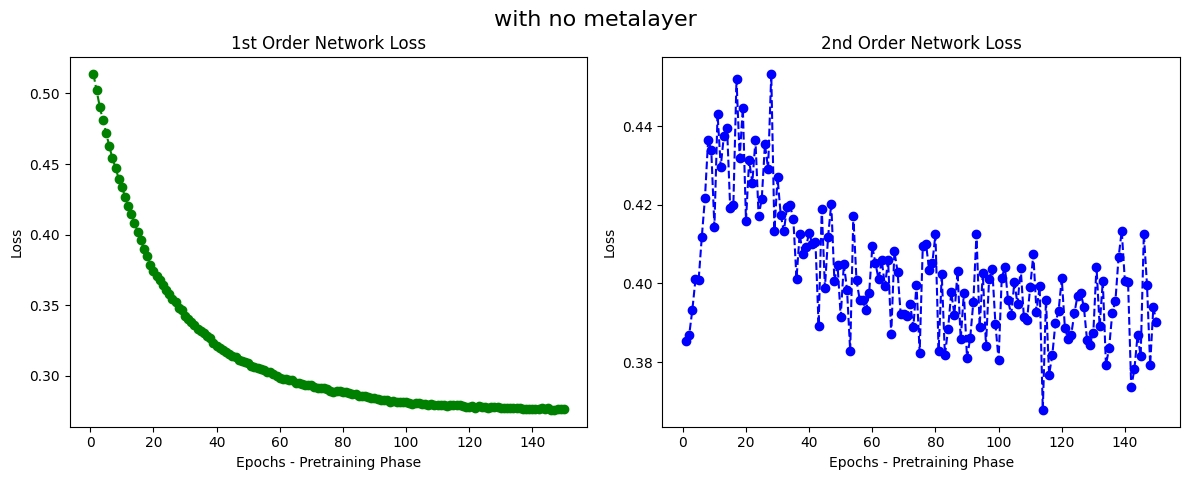

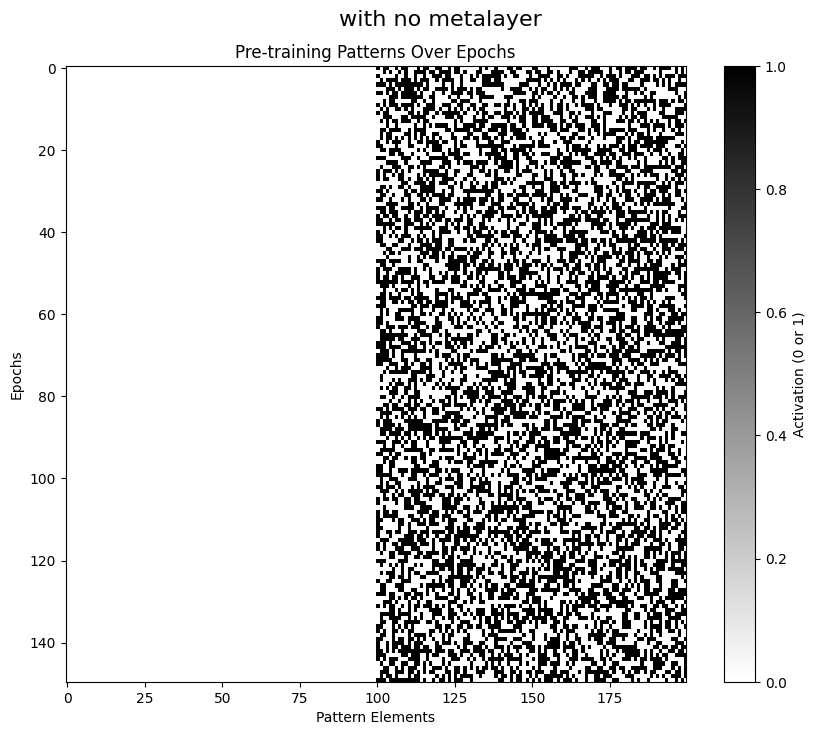

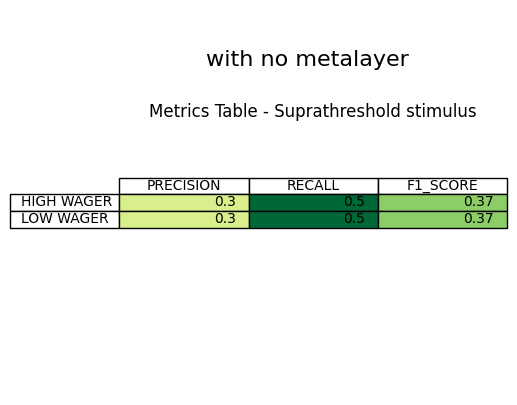

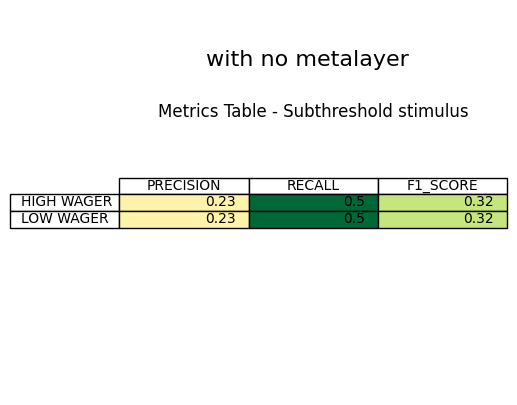

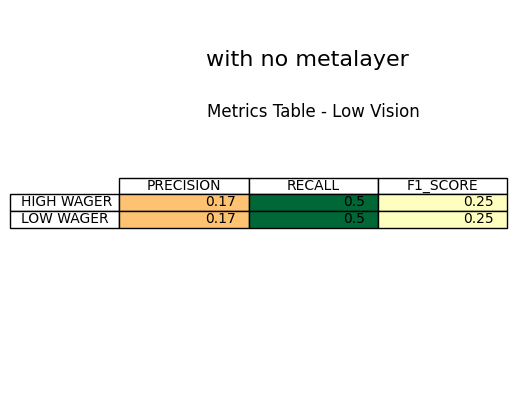

In [ ]:
def initialize_global():
    global Input_Size_1, Hidden_Size_1, Output_Size_1, Input_Size_2
    global num_units, patterns_number
    global learning_rate_1, learning_rate_2, n_epochs, momentum, temperature , Threshold
    global First_set, Second_set, Third_set
    global First_set_targets, Second_set_targets, Third_set_targets
    global epoch_list, epoch_1_order, epoch_2_order, patterns_matrix1
    global Testing_graph_names

    # NETWORK SIZES
    Input_Size_1 = 100
    Hidden_Size_1 = 60
    Output_Size_1 = 100
    Input_Size_2 = 100

    # PATTERNS
    num_units = 100
    patterns_number = 200

    # Pre-training and hyperparameters
    learning_rate_1 = 0.9
    learning_rate_2 = 0.1
    n_epochs = 150
    momentum = 0.0
    temperature = 1.0
    Threshold=0.5

    # Testing
    First_set = []
    Second_set = []
    Third_set = []
    First_set_targets = []
    Second_set_targets = []
    Third_set_targets = []

    # GRAPHIC OF PRETRAINING
    epoch_list = list(range(1, n_epochs + 1))
    epoch_1_order = np.zeros(n_epochs)
    epoch_2_order = np.zeros(n_epochs)
    patterns_matrix1 =  torch.zeros((n_epochs, patterns_number), device=device)  # Initialize patterns_matrix as a PyTorch tensor on the GPU

def title(string):
  #plot the title of the currently trained model, inside a rectangle
  fig, ax = plt.subplots()
  rectangle = patches.Rectangle((0.05, 0.1), 0.9 , 0.4, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.5)
  ax.add_patch(rectangle)
  plt.text(0.5, 0.3, string , horizontalalignment='center', verticalalignment='center', fontsize=26, color='white')
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  ax.axis('off')
  plt.show()
  plt.close(fig)


def main():
    hidden_sizes = [ 50, 60 , 100, 120 , 150, 180 ] #hidden size
    factors = [ 1 ] #factor of data, 10 represents 10 times the amount of data by default in the know thyself paper
    gelus=[ True , False] #True represents using gelu- Gaussian Error Linear Unit , as activation function, False means using relu -Rectified Linear Unit
    step_sizes=[ 1 , 2 , 3 ] #every n number of epochs, the learning rate is updated
    gammas=[ 0.99 , 0.98 , 0.97 , 0.96 ] #the learning rate is multiplied by this factor every step_sizes as defined with the previous hyperparameter
    metalayers=[ True ] #if true, enables training of the 2nd order layer
    num_iterations = 2 #num of times a certain network configuration will be trained and tested

    #initializations for hyperparameter tunning optimization metric
    best_optimization_variable=0

    hyperparameters=list(product(hidden_sizes, factors , gelus  , step_sizes , gammas , metalayers))

    initialize_global()
    title_1="Know Thyself Baseline"
    title(title_1)
    f1_scores_high_wager, f1_scores_low_wager, plot_data = train(60, 1, False, 1, 1.0, True)
    plots(plot_data , title_1)

    for index in range(len(hyperparameters)):
        for _ in range(num_iterations):
          initialize_global()
          f1_scores_high_wager, f1_scores_low_wager, plot_data = train(
            hyperparameters[index][0],
            hyperparameters[index][1],
            hyperparameters[index][2],
            hyperparameters[index][3],
            hyperparameters[index][4],
            hyperparameters[index][5])

          optimization_variable=np.mean(f1_scores_high_wager + f1_scores_low_wager)

          #hyperparameter tunning optimization metric, avergae over max of both high consciousness, low consciousness, and the mean of performance over all trained networks
          if optimization_variable > best_optimization_variable:
                best_optimization_variable= optimization_variable
                best_plot_data = plot_data
                best_f1_high_wager=f1_scores_high_wager
                best_f1_low_wager=f1_scores_low_wager
                best_hidden_size = hyperparameters[index][0]
                best_factor = hyperparameters[index][1]
                best_activation = hyperparameters[index][2]
                best_step_size = hyperparameters[index][3]
                best_gamma = hyperparameters[index][4]
                best_metalayer = hyperparameters[index][5]

    print(f"Best hidden: {best_hidden_size}, Best factor: {best_factor}, Best activation: {best_activation}, Best step size: {best_step_size}, Best gamma: {best_gamma}, Best metalayer: {best_metalayer}, Best F1-scores high wager: {best_f1_high_wager},  Best F1-scores low wager: {best_f1_low_wager}")
    title_2="Best Model w/tunning"
    title(title_2)
    plots(best_plot_data , title_2)

    #Non metalayer testing
    initialize_global()
    f1_scores_high_wager, f1_scores_low_wager, plot_data = train(best_hidden_size, best_factor, best_activation, best_step_size, best_gamma, False)
    title_3="with no metalayer"
    title(title_3)
    plots(plot_data , title_3)

main()